## Q1

#### **Stochastic Processes and Gaussian Processes (GPs)**

**Stochastic Process:**  
A stochastic process is a collection of random variables indexed by a set such as time or space. It can be denoted as  $\{X_t\}_{t \in T}$, where each $X_t$ is a random variable defined on a common probability space, and $T$ is the index set.

**Gaussian Process (GP):**  
A Gaussian Process is a special type of stochastic process. It defines a distribution over functions such that, for any finite set of inputs $x_1, \ldots, x_n$, the function values $f(x_1), \ldots, f(x_n)$ follow a joint multivariate normal distribution.  

It is fully specified by a mean function $m(x)$ and a covariance (kernel) function $k(x, x')$:

$$
f(x) \sim \mathcal{GP}(m(x), k(x, x'))
$$

where  
$m(x) = \mathbb{E}[f(x)]$ and  
$k(x, x') = \mathbb{E}[(f(x) - m(x))(f(x') - m(x'))]$.

---

#### **Variational Inference using the Evidence Lower Bound (ELBO)**

**Variational Inference (VI):**  
VI approximates the true posterior $p(\theta \mid x)$ using a simpler distribution $q(\theta)$. The objective is to minimize the Kullback-Leibler (KL) divergence:

$$
\mathrm{KL}(q(\theta) \| p(\theta \mid x)) = \log p(x) - \text{ELBO}(q)
$$

**Evidence Lower Bound (ELBO):**  
The ELBO provides a lower bound on the log marginal likelihood $\log p(x)$ and serves as the optimization objective in variational inference:

$$
\text{ELBO}(q) = \mathbb{E}_{q(\theta)}[\log p(x, \theta)] - \mathbb{E}_{q(\theta)}[\log q(\theta)]
$$

Maximizing the ELBO is equivalent to minimizing the KL divergence, encouraging $q(\theta)$ to closely approximate the true posterior while regularizing complexity.

/opt/conda/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [lengthscale, scale, noise]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 35 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [f_pred]


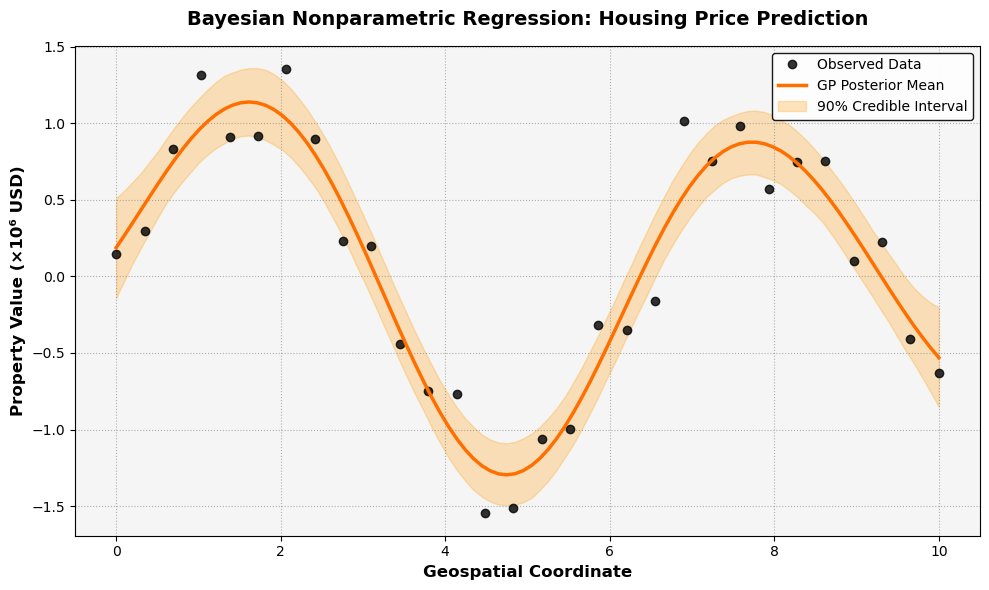

In [13]:
# Q2
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az  

# Generate synthetic data
np.random.seed(1007818630)
X = np.linspace(0, 10, 30)[:, None]
y = np.sin(X).ravel() + 0.3 * np.random.randn(1007818630)

# Build GP model
with pm.Model() as model:
    # Priors
    lengthscale = pm.Gamma("lengthscale", alpha=2, beta=1)
    scale = pm.HalfNormal("scale", sigma=1.0)
    
    # Covariance function
    cov_func = scale**2 * pm.gp.cov.ExpQuad(1, lengthscale)
    gp = pm.gp.Marginal(cov_func=cov_func)
    
    # Noise term
    noise = pm.HalfNormal("noise", sigma=0.5)
    
    # Likelihood
    y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=noise)
    
    # Sampling
    trace = pm.sample(1000, chains=2, random_seed=1007818630)

    # Predictions
    X_new = np.linspace(0, 10, 100)[:, None]
    f_pred = gp.conditional("f_pred", X_new)
    
    
    posterior_samples = pm.sample_posterior_predictive(
        trace, 
        var_names=["f_pred"], 
        predictions=True  
    )

if hasattr(posterior_samples, "predictions"):  
    f_pred = posterior_samples.predictions["f_pred"].values
    f_pred = f_pred.reshape(-1, 100)  
else:
    f_pred = posterior_samples["f_pred"]

mean_pred = f_pred.mean(axis=0)
lower = np.percentile(f_pred, 5, axis=0)
upper = np.percentile(f_pred, 95, axis=0)

# Visualize 
plt.figure(figsize=(10, 6))
plt.plot(X, y, 'o', label="Observed Data", color='black', markersize=6, alpha=0.8)
plt.plot(X_new, mean_pred, label="GP Posterior Mean", color='#FF6F00', linewidth=2.5)
plt.fill_between(
    X_new.ravel(), 
    lower, 
    upper, 
    color='#FFA726', 
    alpha=0.3, 
    label="90% Credible Interval"
)

plt.xlabel("Geospatial Coordinate", fontsize=12, fontweight='bold')
plt.ylabel("Property Value (×10⁶ USD)", fontsize=12, fontweight='bold')
plt.title("Bayesian Nonparametric Regression: Housing Price Prediction", 
          fontsize=14, pad=15, fontweight='bold')
plt.legend(loc='upper right', framealpha=0.9, edgecolor='black')
plt.grid(True, linestyle=':', color='gray', alpha=0.6)
plt.gca().set_facecolor('#F5F5F5')
plt.tight_layout()
plt.show()

Finished [100%]: Average Loss = 188.3


<Figure size 1000x600 with 0 Axes>

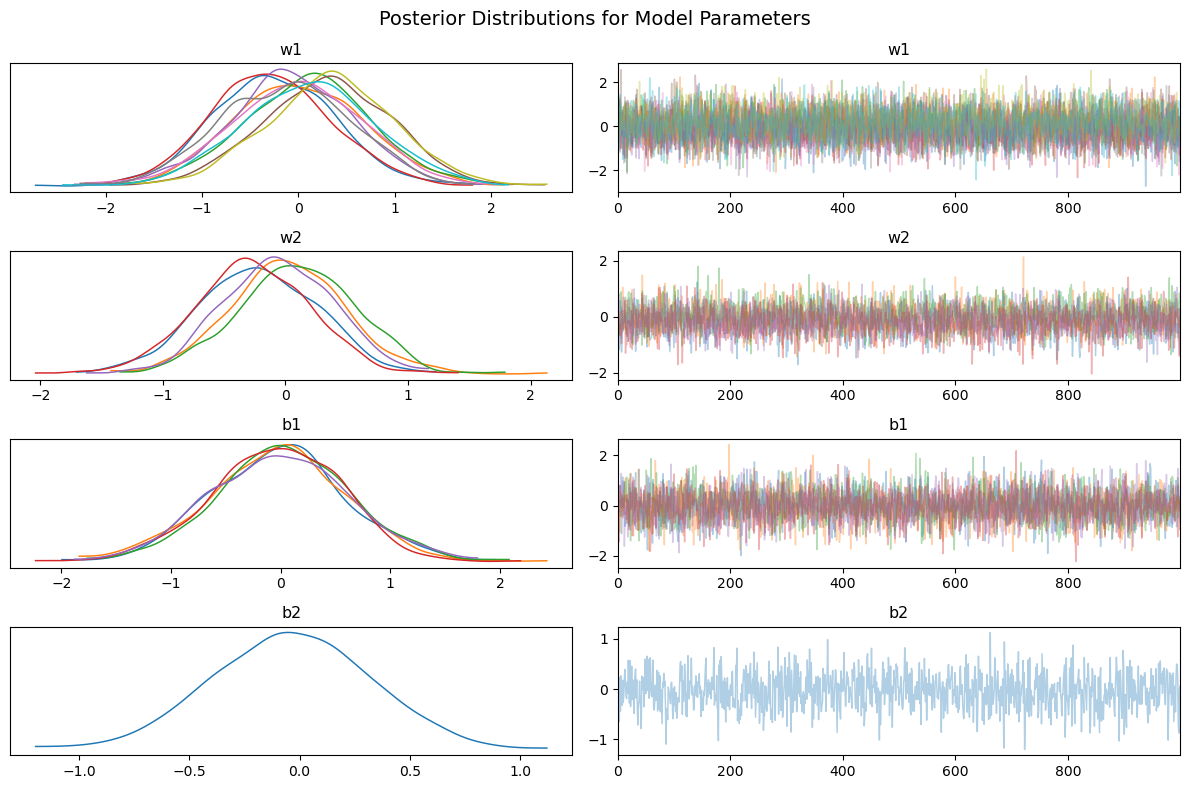

In [5]:
# Q3

import pymc as pm
import numpy as np
import pytensor.tensor as pt
import matplotlib.pyplot as plt

# Simulate data for binary classification
np.random.seed(1007818630)
X = np.random.randn(250, 2)  
w_true = np.array([1.5, -2.0])  
logits = X @ w_true  
y = np.random.binomial(n=1, p=1 / (1 + np.exp(-logits)))  

# Define the model using PyMC
with pm.Model() as vi_model:
    # First layer: 2 inputs -> 5 hidden units
    w1 = pm.Normal("w1", mu=0, sigma=1, shape=(2, 5))  
    b1 = pm.Normal("b1", mu=0, sigma=1, shape=(5,))   

    # Second layer: 5 hidden units -> 1 output (logits)
    w2 = pm.Normal("w2", mu=0, sigma=1, shape=(5,))   
    b2 = pm.Normal("b2", mu=0, sigma=1)                
    
    # Forward pass: hidden layer with tanh activation
    hidden = pm.math.tanh(pt.dot(X, w1) + b1)           
    output = pt.dot(hidden, w2) + b2                  

    # Likelihood: Logistic regression (Bernoulli distribution)
    y_obs = pm.Bernoulli("y_obs", logit_p=output, observed=y)

    # Fit the model using Automatic Differentiation Variational Inference (ADVI)
    approx = pm.fit(10000, method="advi", obj_optimizer=pm.adagrad(learning_rate=0.01))
    
    # Sample from the approximate posterior distribution
    trace_vi = approx.sample(1000)

# Visualize the posterior distributions of the model parameters
plt.figure(figsize=(10, 6))
pm.plot_trace(trace_vi, var_names=["w1", "w2", "b1", "b2"])  # Replaced traceplot with plot_trace
plt.suptitle("Posterior Distributions for Model Parameters", fontsize=14)
plt.tight_layout()
plt.show()
